In [46]:
# CS614 Assignment #1 
## Vision
### Author: Cory W. Mauer

## Pitch:

My Original idea for this project was inspired when scrolling through instagram looking at popular tatoo artists work. The challenge with this is I am often looking for ideas for work, without wanting to make a direct copy of something that already exists. Based on this idea I theorized the idea of building web site that enabled users to view autogenerated art images as a means for inspiration toward their own artwork. 

## Data source:
During my initial investigation of data sets to use for this project I initial was looking to either track down an existing data set of tattoo related art, however unsuprisingly I was not able to find any. 

Following that discovery I decided I wanted to track down more general art related data. While I was able to find some, most had inconsistent large and/or inconsistent image sizing which made the process more difficult. 

For this project I finally decided to leverage the [Ciphar-10 data set](https://www.tensorflow.org/datasets/catalog/cifar10) (https://www.tensorflow.org/datasets/catalog/cifar10) as it provided my with an easily accessible large, color, and tagged dataset leveraging a wide variety of classes. Originally I expected very poor performance when using this data set, however after using it I was happily surprised by the results. They say that art imitates life, and in this case the combination of data from seemingly randomly classes tends to actually produce some very interesting images.

here are same examples from the data set with class labels

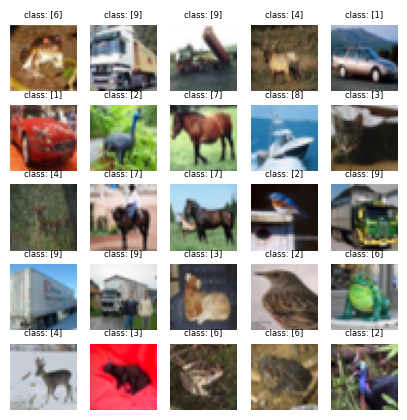

In [47]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from matplotlib import pyplot as plt


(train_images, train_labels), (_, _) = cifar10.load_data()

figure_size = {"length": 5, "width":5}
fig = plt.figure(figsize=(figure_size["length"],figure_size["width"]))
for i in range(figure_size["length"]* figure_size["width"]):
    plt.subplot(figure_size["length"], figure_size["width"], i+1)
    plt.title(f"class: {train_labels[i]}", fontsize=6)
    plt.imshow((train_images[i, :, :, :]))
    plt.axis('off')


Given more time and compute resources, I would like to build or aquire larger and more targeted datasets. With these larger data sets I would hope to build higher resolution artwork that can better target specific use cases.

## Model and Data Justification
For this task I chose to use a GAN for the image generation. Prior to this project I had read about GAN's at a high level but never actually implemented one. Given more time and compute resources I would have liked to have explored a more cutting edge model such as a diffusion model. 

During my GAN development, I orignally started with a simple GAN consisting of convolutional transpose layers with relatively few chanels.

best gan generator    

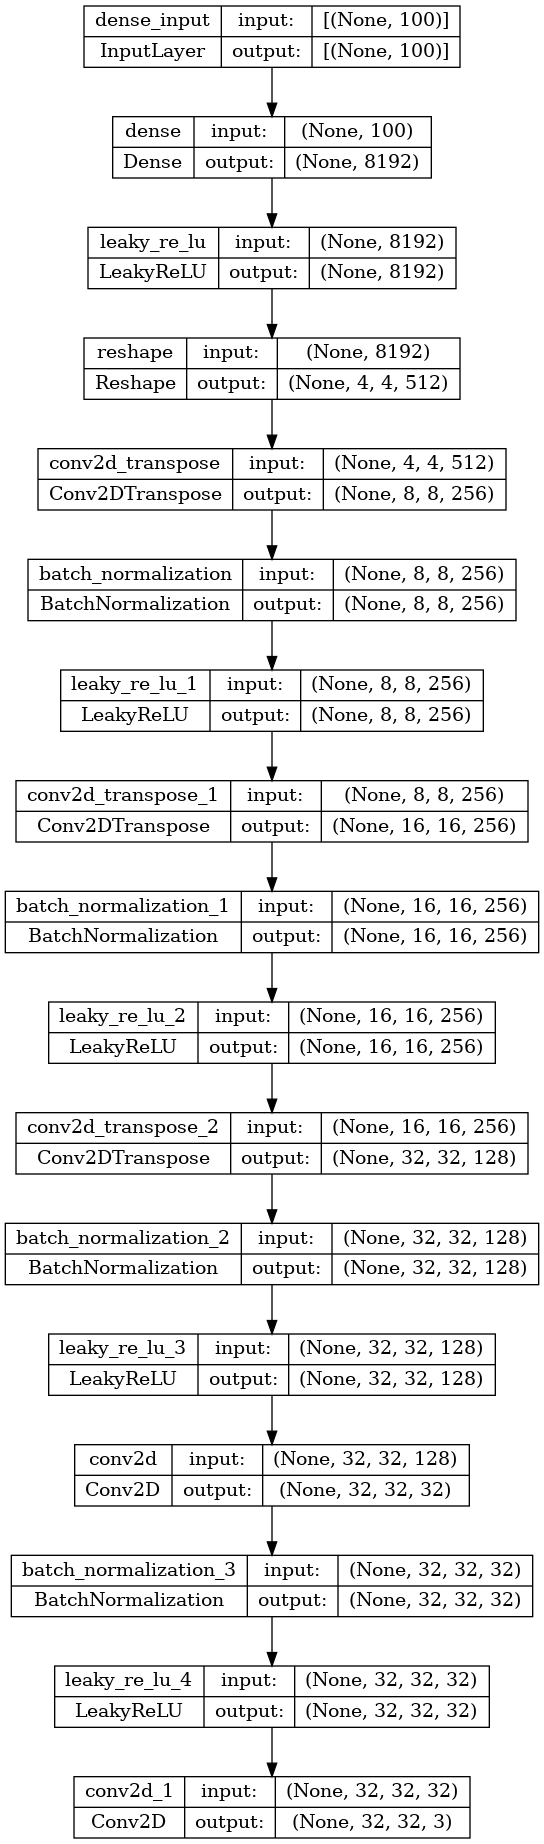

In [48]:
from IPython.display import display, Image
display(Image(filename="./model_plots/generator_plot.png", height=400, width=400))

best gan discriminator

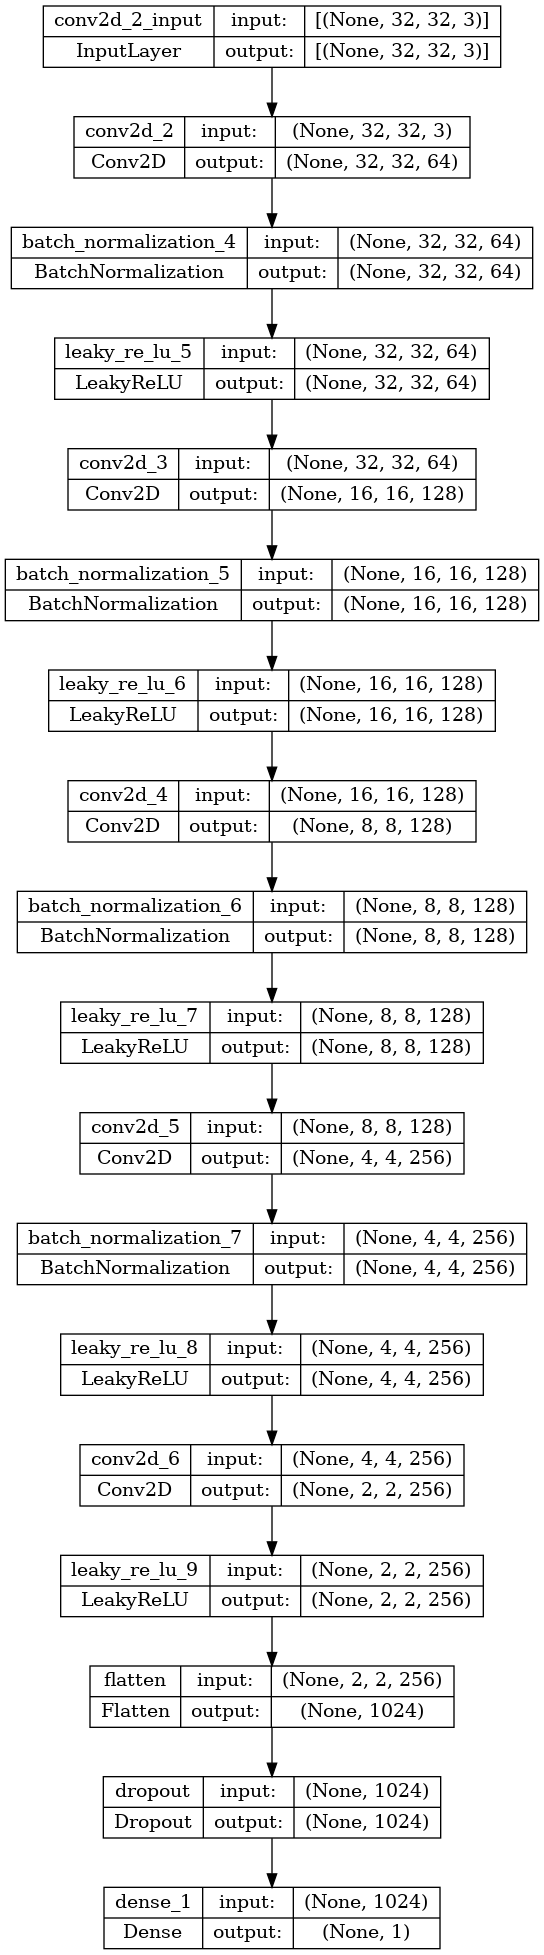

In [49]:
display(Image(filename="./model_plots/discriminator_plot.png", height=400, width=400))



I did start exploring using classification in effort to create a conditional GAN, but didn't have great success with training.

cgan generator

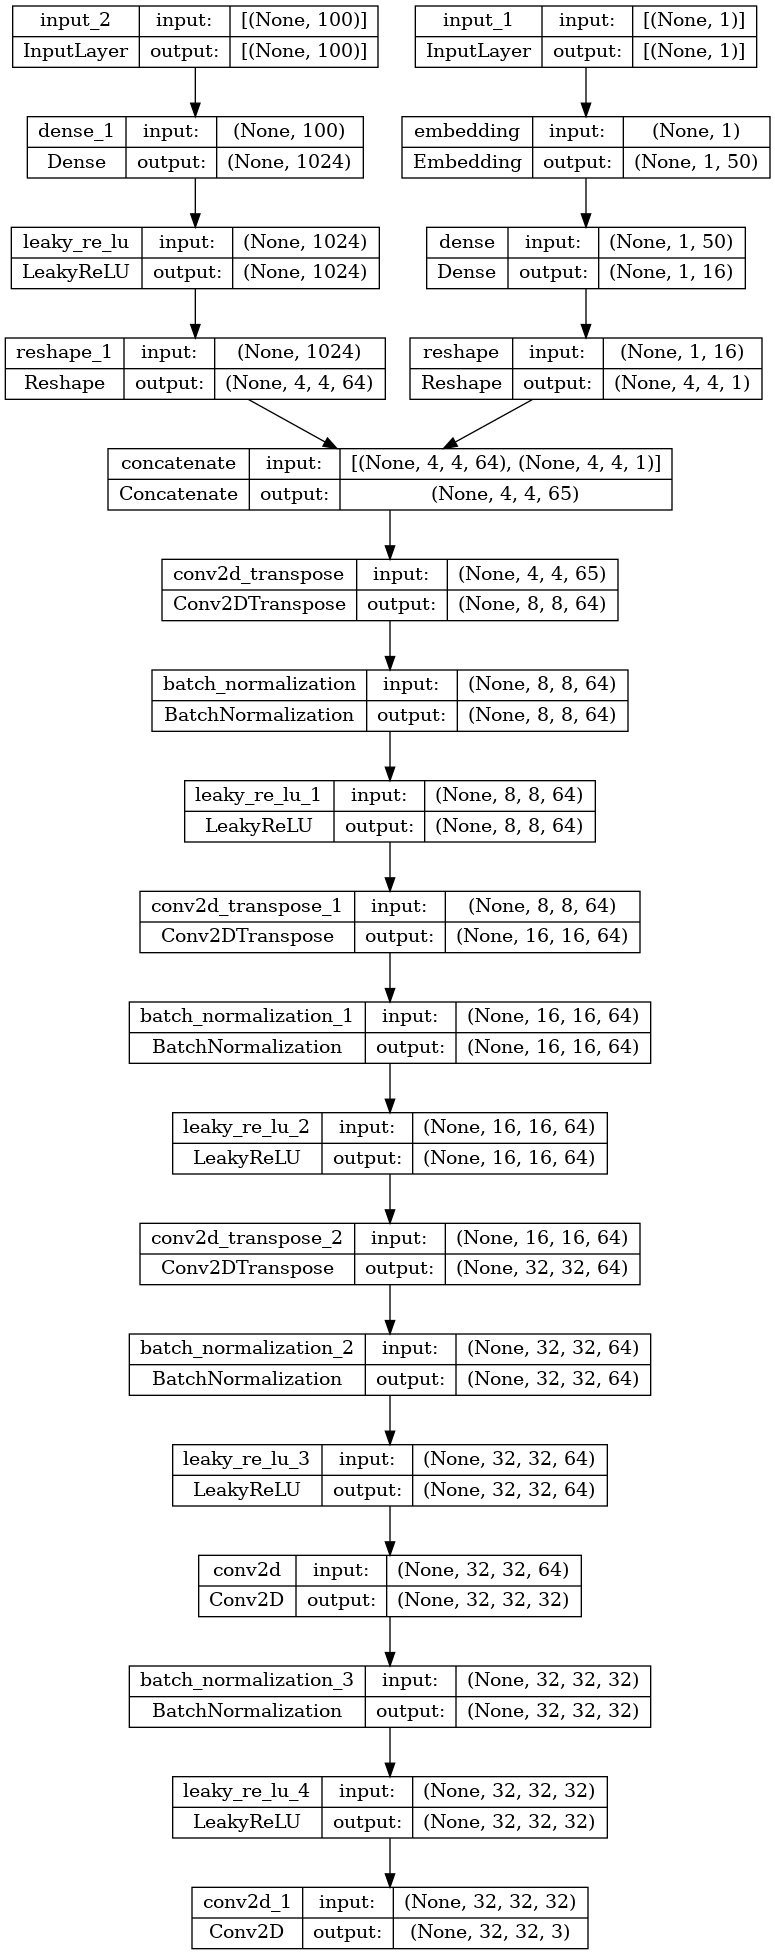

In [50]:
display(Image(filename="./model_plots/cgan_gen_plot.png", height=400, width=400))

cgan discriminator

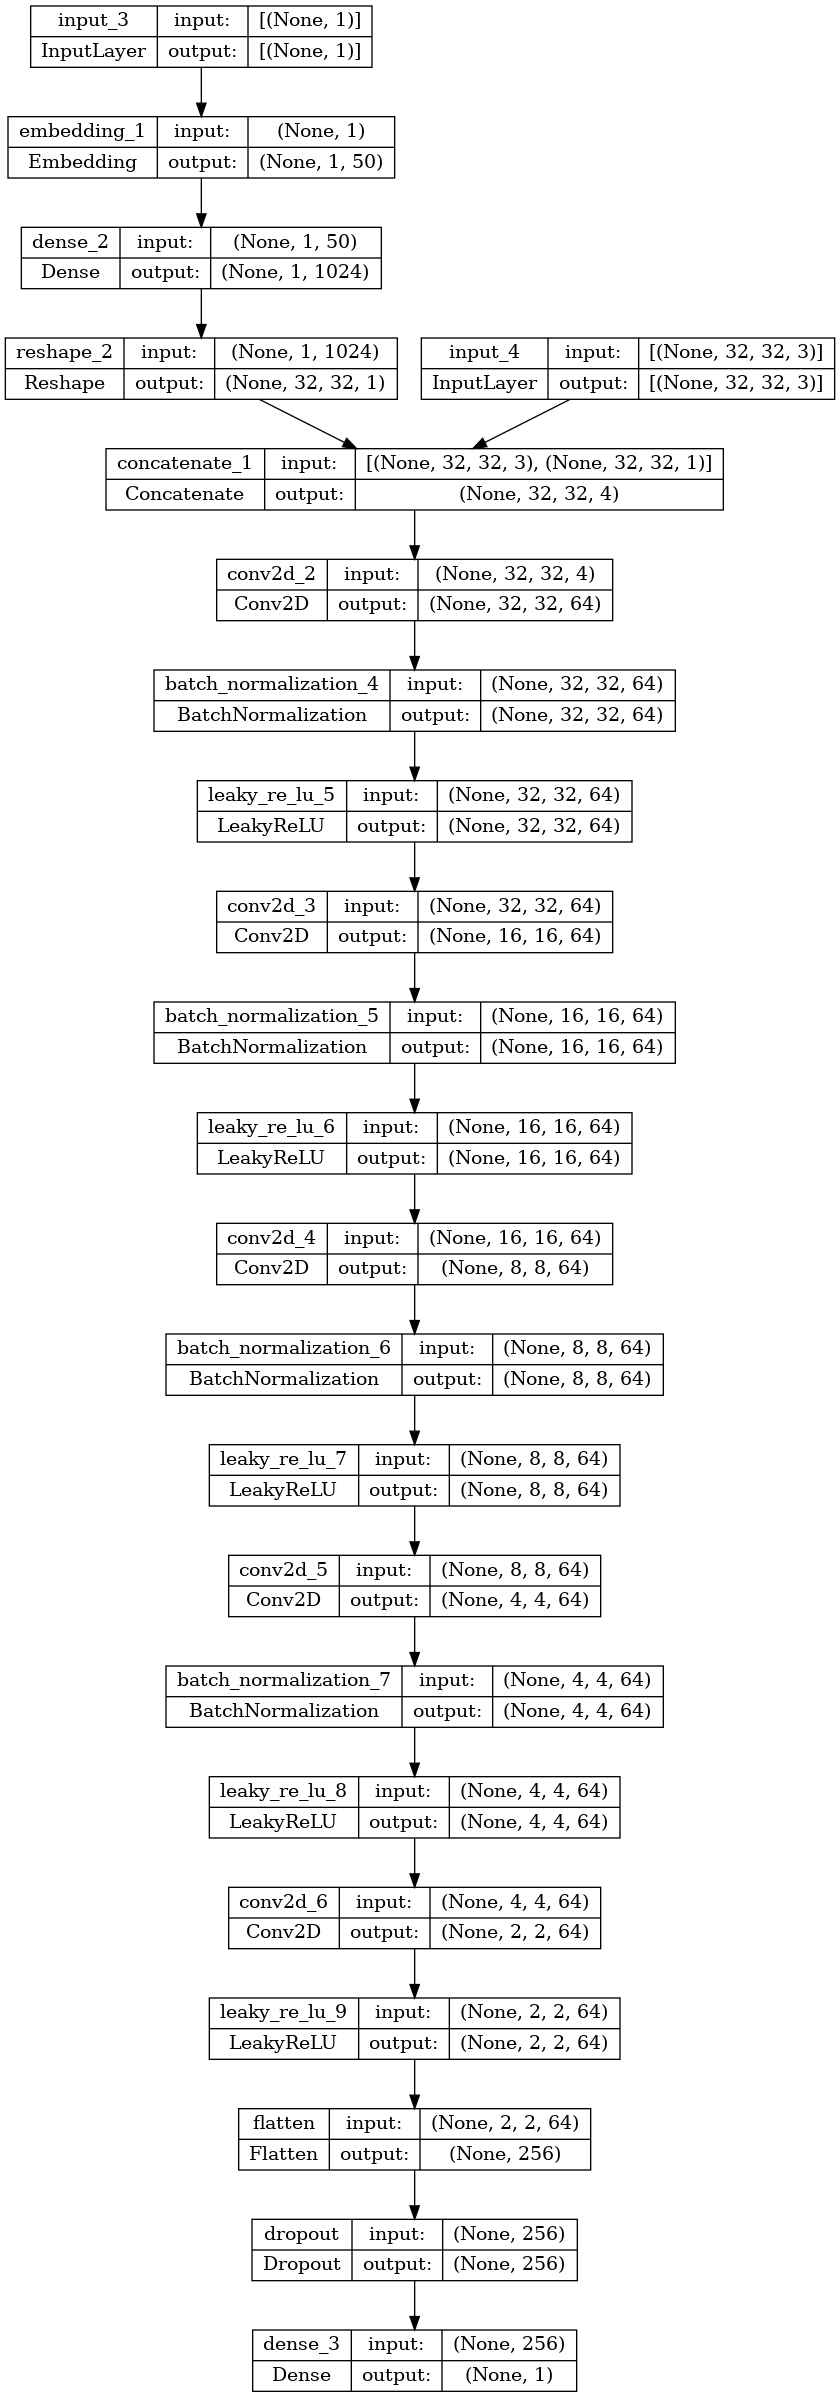

In [51]:
display(Image(filename="./model_plots/cgan_discriminator_plot.png", height=400, width=400))

## Commented examples
The following provides some commented code snip its of the model. for more details see the training script `cifar10_gan.py`


In [52]:
from tensorflow.keras import layers
# Generator model
def make_generator_model():
    model = tf.keras.Sequential()
    n_nodes = [4, 4, 512]
    model.add(layers.Dense(n_nodes[0] * n_nodes[1]* n_nodes[2], input_dim=100))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape(n_nodes))
    model.add(layers.Conv2DTranspose(256, (4,4), strides=(2,2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2DTranspose(256, (4,4), strides=(2,2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(32, (3,3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

generator = make_generator_model()
print(f"generator \n {generator.summary()}")

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_4 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 8, 8, 256)        2097408   
 Transpose)                                                      
                                                                 
 batch_normalization_32 (Bat  (None, 8, 8, 256)        1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_41 (LeakyReLU)  (None, 8, 8, 256)        

In [53]:
# Discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3,3), padding='same', input_shape=(32,32,3)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

discriminator = make_discriminator_model()
print(f"discriminator \n {discriminator.summary()}")

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_36 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_45 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_31 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 batch_normalization_37 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_46 (LeakyReLU)  (None, 16, 16, 128)      

## Testing

Initial testing using these gan models focused on training data from a single class from the cifar data set. In this case we will demonstrate the model being trained with automobile images. Notice the quality of the relatively high quality of the images that make it easy to tell that a car. The homogenous nature of the images all being cars allow for a model that cleary produces car images.

1/1 [==============================] - 0s 134ms/step


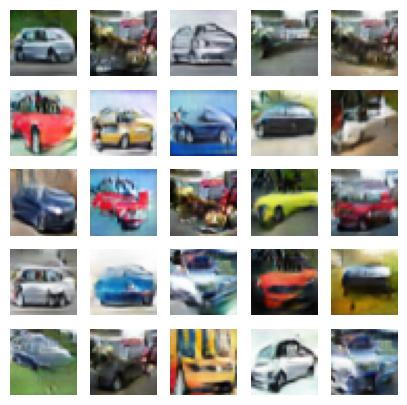

In [54]:
generator = tf.keras.models.load_model("./car_generator")
figure_size = {"length": 5, "width": 5}
number_of_generated_images = figure_size['length'] * figure_size['width']
noise = tf.random.normal([number_of_generated_images, 100])
generated_images = generator.predict(noise)
generated_images = (generated_images * 127.5 + 127.5).astype(int)

fig = plt.figure(figsize=(figure_size["length"],figure_size["width"]), dpi= 100)
for i in range(figure_size["length"]* figure_size["width"]):
    plt.subplot(figure_size["length"], figure_size["width"], i+1)
    plt.imshow((generated_images[i, :, :, :]))
    plt.axis('off')


After this I decided look into how I could make artistic looking images. I found that by training my models with all classes of image from the cifar dataset I was able to create images that mix features of each of the classes and make unique but familiar images. 

4/4 [==============================] - 0s 20ms/step


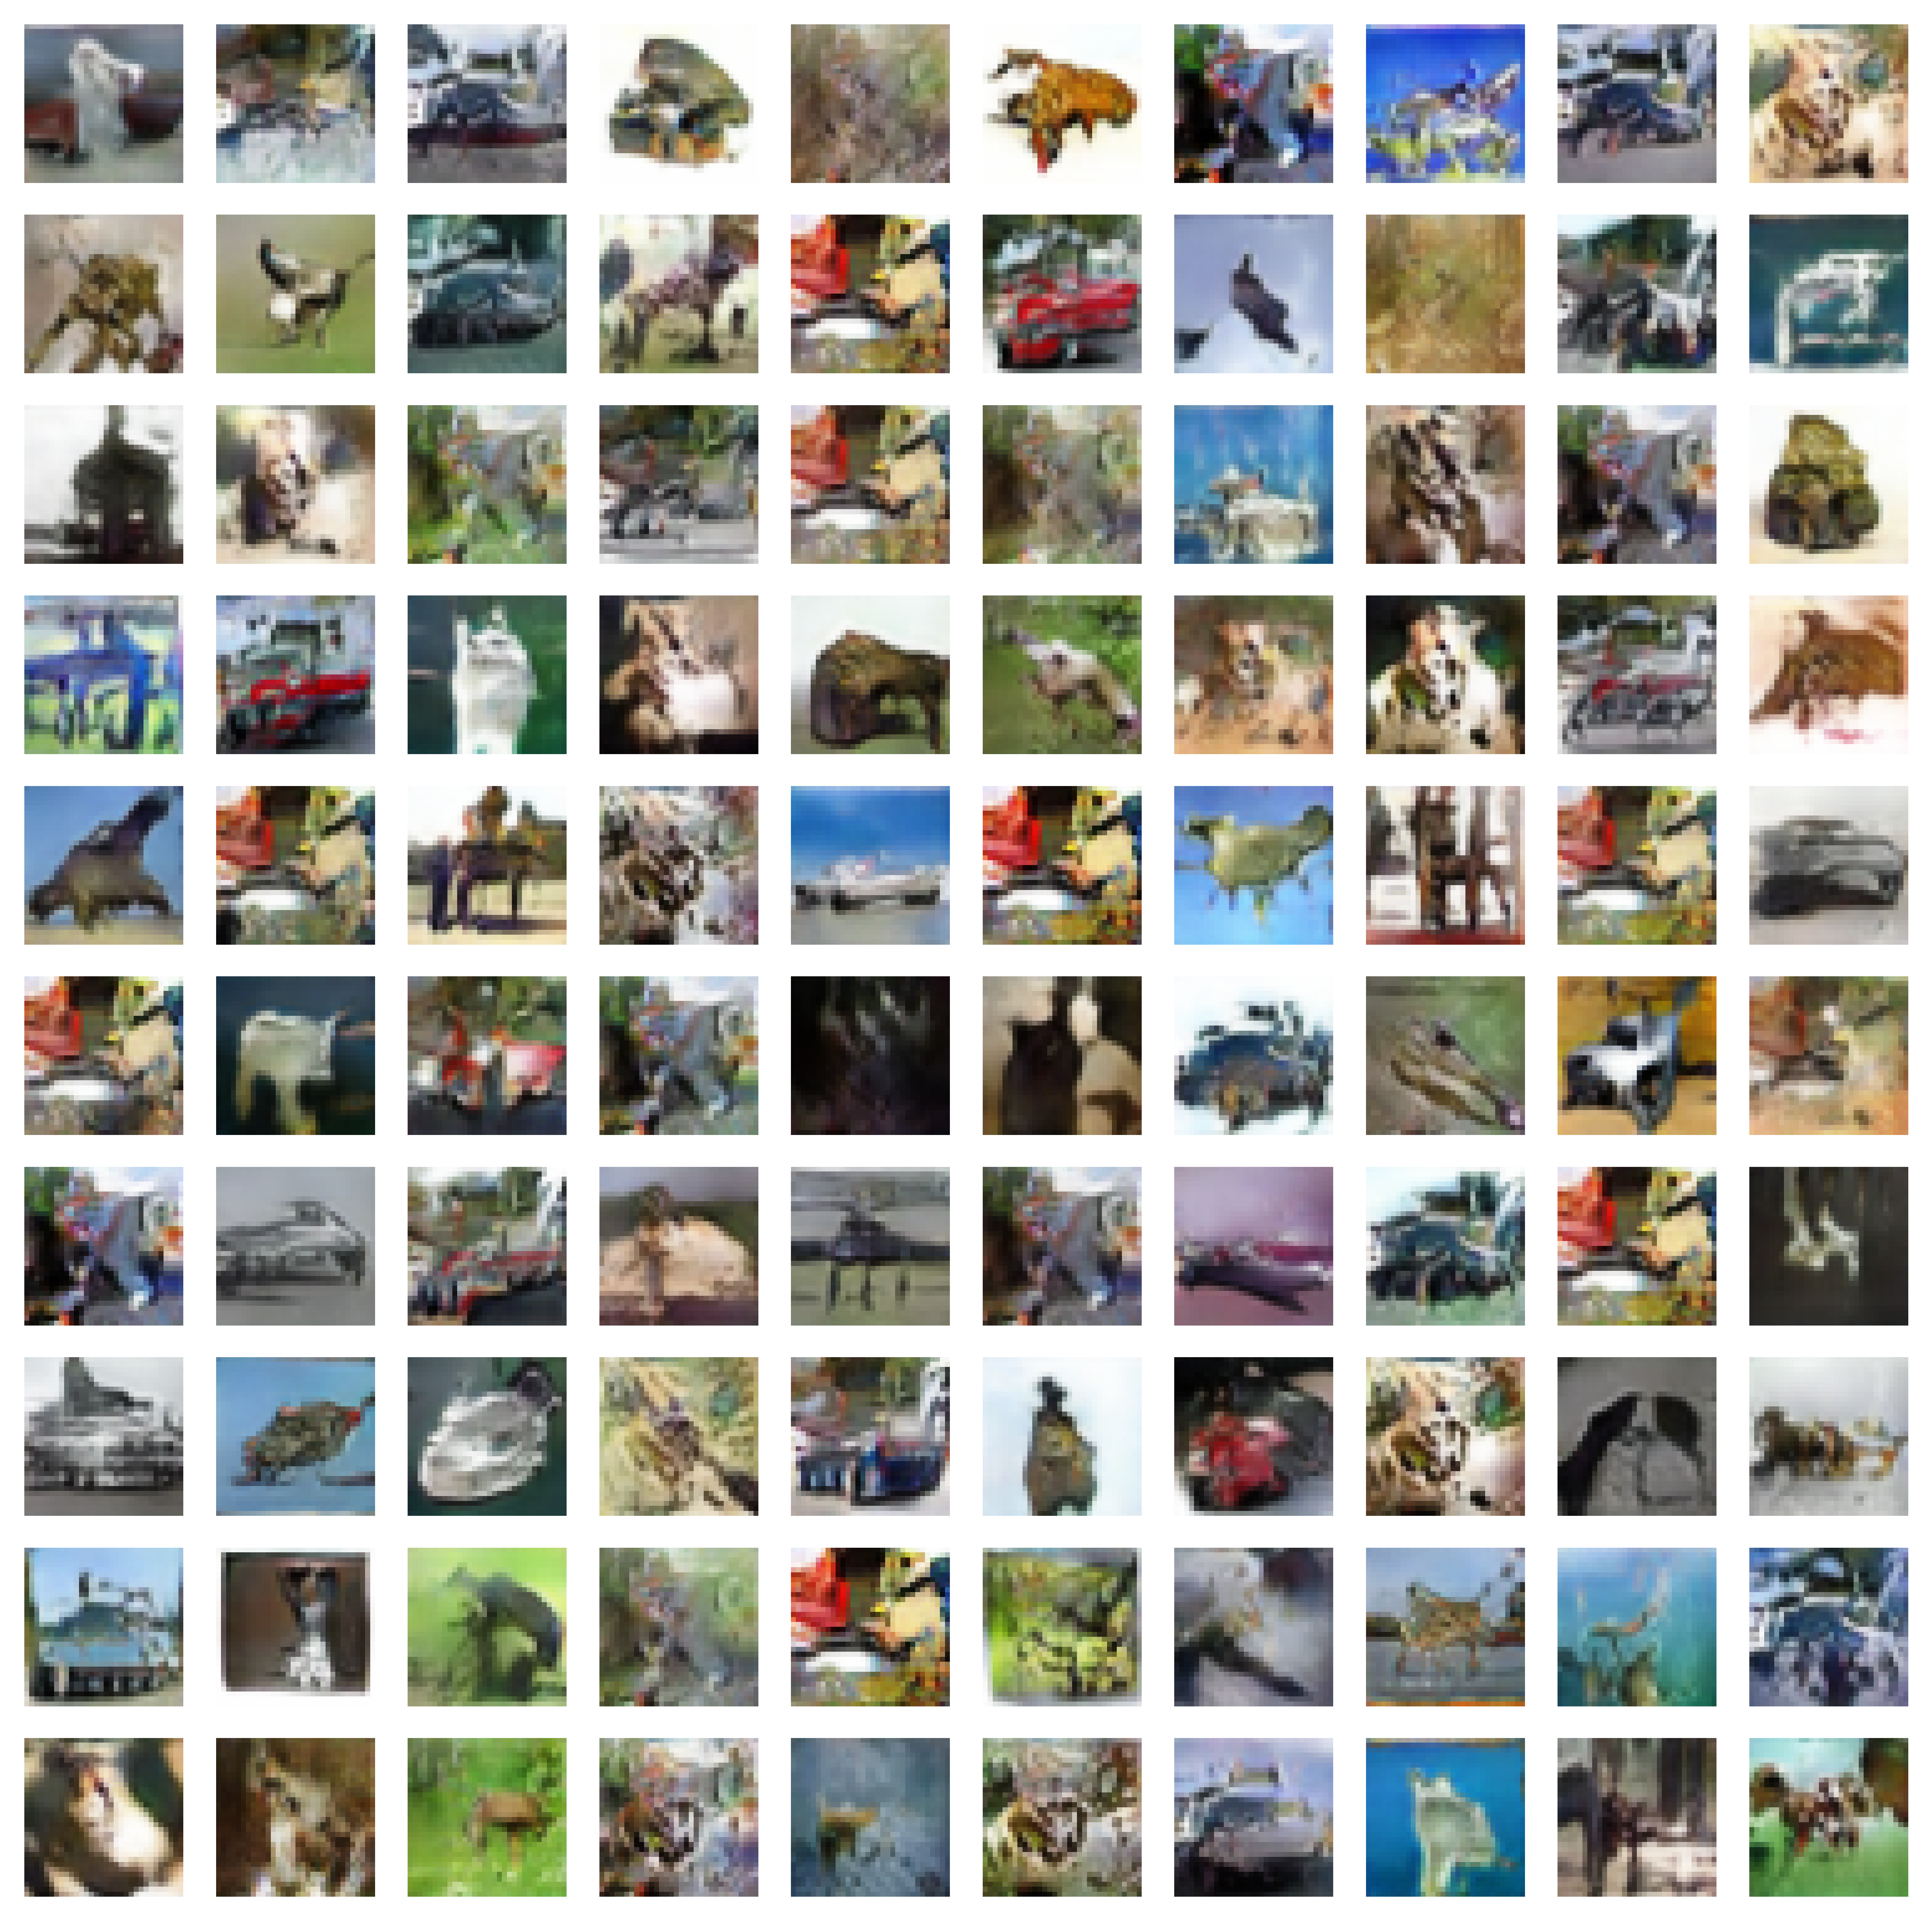

In [55]:

generator = tf.keras.models.load_model("./gan10_generator")
figure_size = {"length": 10, "width":10}
number_of_generated_images = figure_size['length'] * figure_size['width']
noise = tf.random.normal([number_of_generated_images, 100])
generated_images = generator.predict(noise)
generated_images = (generated_images * 127.5 + 127.5).astype(int)

fig = plt.figure(figsize=(figure_size["length"],figure_size["width"]), dpi= 800)
for i in range(figure_size["length"]* figure_size["width"]):
    plt.subplot(figure_size["length"], figure_size["width"], i+1)
    plt.imshow((generated_images[i, :, :, :]))
    plt.axis('off')


## Code and instructions to run it
Code can be found on my github at [cs614](https://github.com/cwma86/cs614)(https://github.com/cwma86/cs614)
The model training code exists in `./cifar10_gan.py`. 
the pre-trained model can be found at `gan10_generator` and `gan10_discriminator`

to add more training epoch run 

`./cifar10_gan.py --gen gan10_generator --disc gan10_discriminator` 

to see super resolved version of the generated images 

`./super_resolution.py gan10_generator`